In [37]:
import sys

sys.path.append("..")

%load_ext autoreload
%autoreload complete

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
from math import ceil
from functools import partial
from pathlib import Path
import datetime
import pickle

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import dask
import cftime
from sklearn.decomposition import FactorAnalysis, PCA
import scipy
import cmocean

from lmrecon.io import IntakeESMLoader, save_mfdataset, open_mfdataset
from lmrecon.util import (
    stack_state,
    unstack_state,
    is_dask_array,
    get_data_path,
    to_math_order,
    to_cf_order,
    round_to,
    NanMask,
    is_ocean_field,
)
from lmrecon.eof import EOF, EOFMethod
from lmrecon.mapper import PhysicalSpaceForecastSpaceMapper
from lmrecon.logger import logging_disabled
from lmrecon.stats import average_annually, area_weighted_rmse, compute_field_stds
from lmrecon.plotting import plot_field, save_plot, format_plot, get_field_label, add_subplot_headers, get_field_shorthand_label, subplots_cartopy

In [39]:
def plot_eigenvalues(eof, n, name):
    fig, ax = plt.subplots(figsize=(12, 5))

    n = min(n, len(eof.variance_fraction_per_mode))
    spectrum = eof.variance_fraction_per_mode[:n] * 100
    intervals = eof.variance_fraction_per_mode_ci[:n] * 100

    ax.errorbar(range(1, n + 1), spectrum, intervals, capsize=5)
    # ax.set_ylim([0, ax.get_ylim()[1]])
    ax.set_ylabel("Fraction of variance [%]")
    ax.set_xlabel("EOF")
    format_plot(major_grid=True)
    ax.set_yscale("log")

    save_plot(plots_folder, f"eigenvalues_{name}")

In [40]:
def plot_cumulative_variance_individual(fields=None):
    fig, ax = plt.subplots()

    if fields is None:
        fields = mapper.eofs_individual.keys()
    for f in fields:
        eof = mapper.eofs_individual[f]
        ax.plot(np.arange(1, eof.rank+1), np.cumsum(eof.variance_fraction_per_mode) * 100,
                label=get_field_label(f))

    ax.legend(ncols=2)
    ax.set_xlabel("Retained number of EOFs")
    ax.set_ylabel("Fraction of variance [%]")
    ax.set_xlim(1, eof.rank)
    ax.set_ylim(0, 100)

    format_plot(major_grid=True)
    save_plot(plots_folder, "variance_retained_individual_eof")

# Seasonal

In [41]:
plots_folder = "../plots/joint_eof_seasonal"
# mapper_id = "2025-02-17T17-45-16"  # MPI past2k
mapper_id = "2025-02-17T17-51-54"  # CESM2 past1000
# mapper_id = "2025-02-17T18-35-32"  # MIROC past1000
# mapper_id = "2025-03-24T18-16-57"  # MRI past1000 + Historical
# mapper_id = "2025-02-17T18-37-45"  # MRI past1000

In [42]:
mapper = PhysicalSpaceForecastSpaceMapper.load(
    get_data_path() / "mapper" / mapper_id / "mapper.pkl"
)

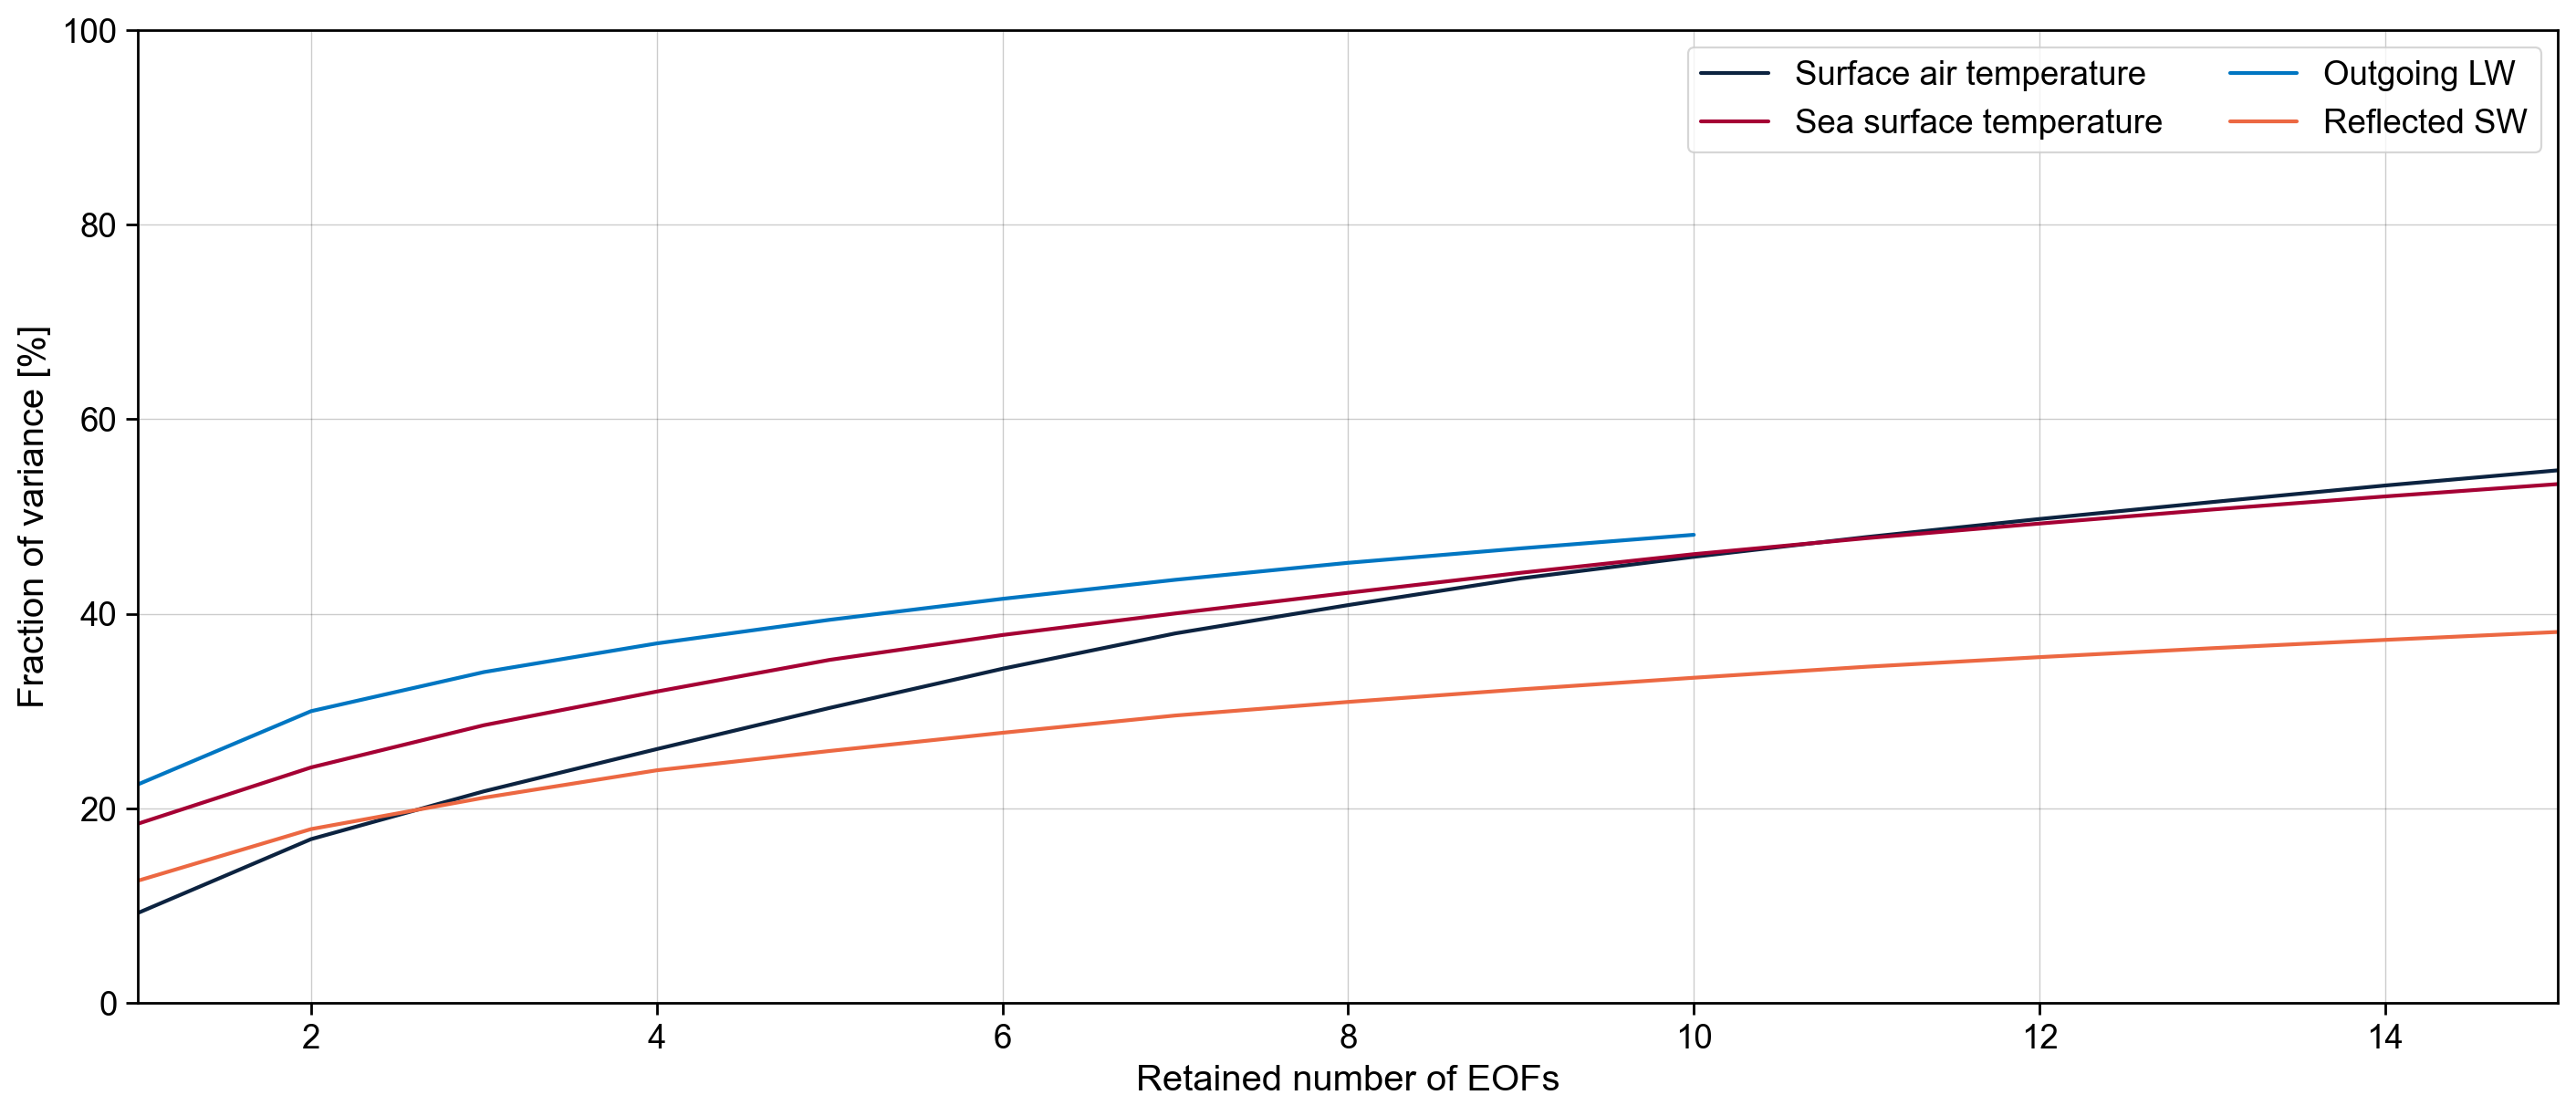

In [7]:
# plot_cumulative_variance_individual(["tas", "tos", "rsut", "rlut", "eei", "ohc300", "ohc700", "siconcn", "siconcs"])
plot_cumulative_variance_individual(["tas", "tos", "rlut", "rsut"])

In [8]:
mapper.eofs_individual["tas"].variance_fraction_per_mode

array([0.09239523, 0.07580318, 0.04918404, 0.04340505, 0.04232849,
       0.04029212, 0.0363746 , 0.02909524, 0.0274995 , 0.02213684,
       0.02035778, 0.01854905, 0.0174437 , 0.01700634, 0.01561592,
       0.01388608, 0.01158176, 0.01153271, 0.01028634, 0.00949841])

(0.35, 80.0)

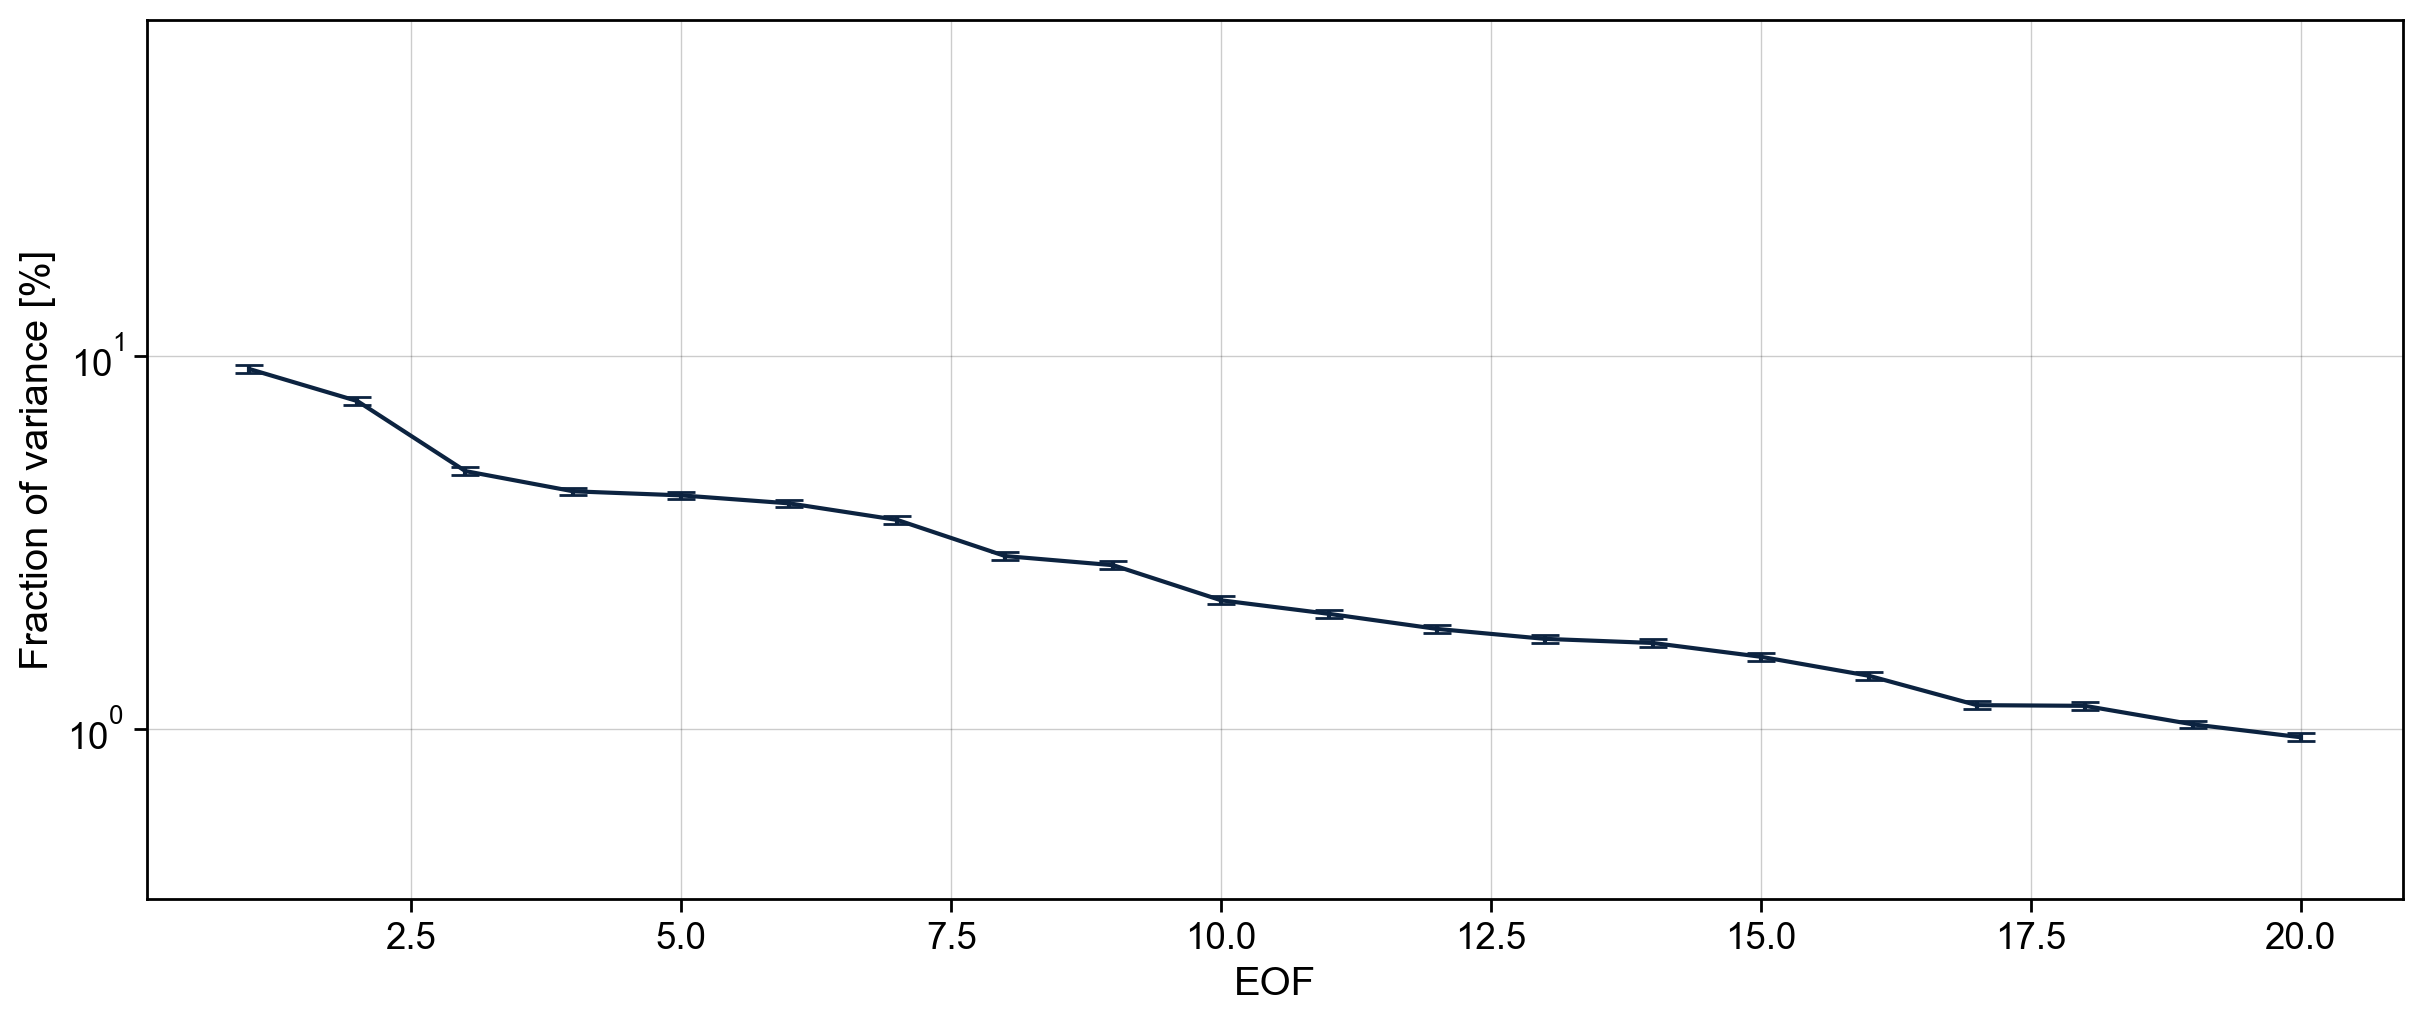

In [9]:
plot_eigenvalues(mapper.eofs_individual["tas"], 30, "tas")
plt.ylim(3.5e-1, 8e1)

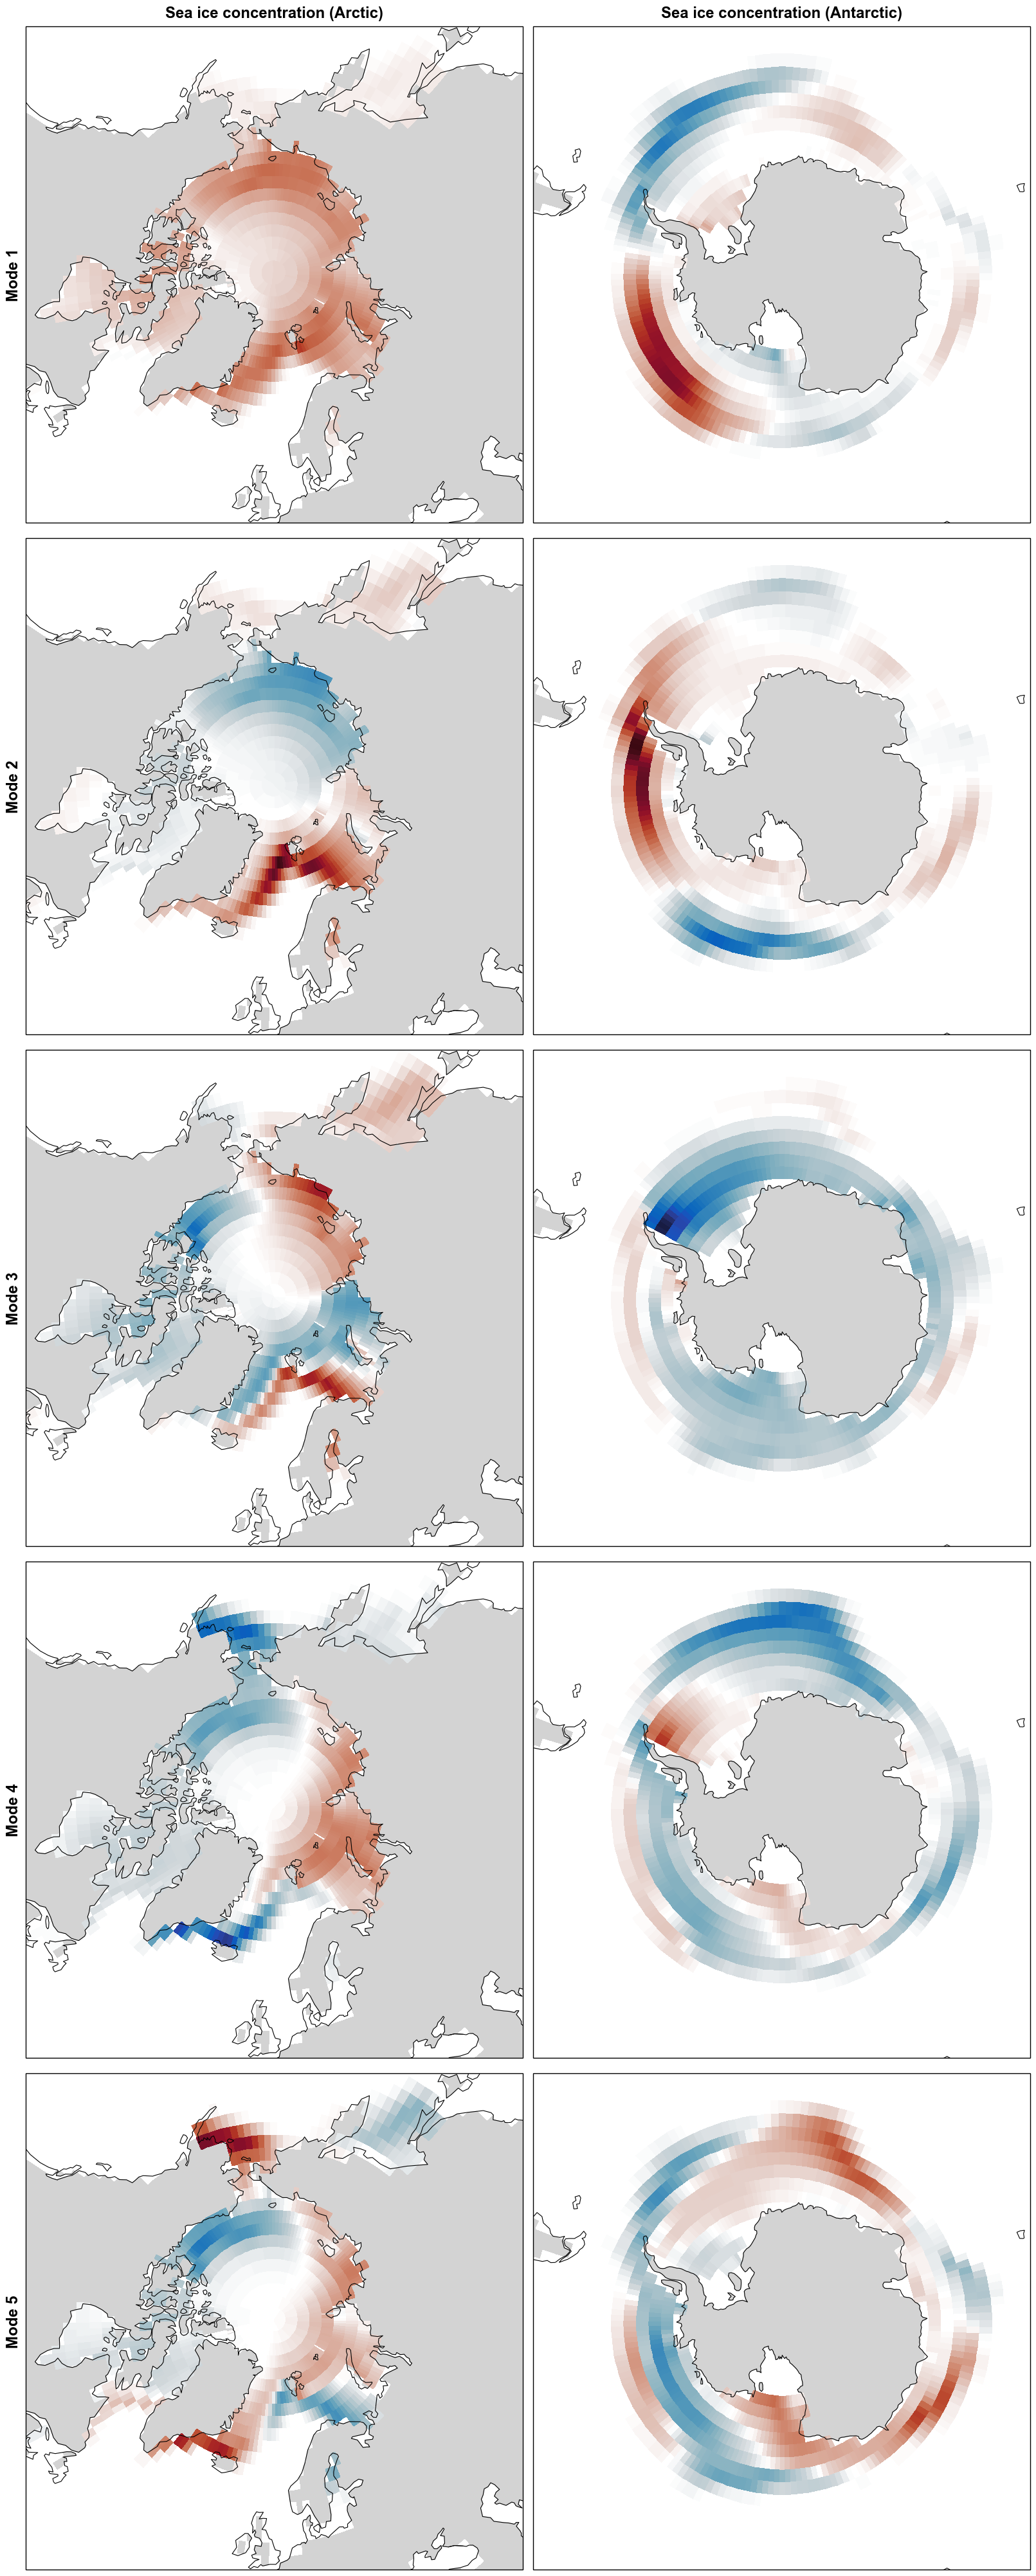

In [43]:
def visualize_individual_eof(
    n_leading=5,
    fields=[
        # "tas",
        "siconc",
        # "tas",
        # "rsut",
        # "eei",
        # "rlut",
    ],
):
    height = 4
    if "siconc" in fields:
        height = 8
        fields.remove("siconc")
        fields.extend(["siconcn", "siconcs"])

    fig = plt.figure(figsize=(8*len(fields), height*n_leading), dpi=100)
    axs = np.empty((n_leading, len(fields)), dtype=object)
    gs = fig.add_gridspec(n_leading, len(fields))
    for i in range(n_leading):
        for j, field in enumerate(fields):
            if field == "siconcn":
                axs[i, j] = fig.add_subplot(gs[i, j], projection=ccrs.NorthPolarStereo())
                axs[i, j].set_extent([0, 360, 50, 90], crs=ccrs.PlateCarree())
            elif field == "siconcs":
                axs[i, j] = fig.add_subplot(gs[i, j], projection=ccrs.SouthPolarStereo())
                axs[i, j].set_extent([0, 360, -90, -50], crs=ccrs.PlateCarree())
            else:
                axs[i, j] = fig.add_subplot(gs[i, j], projection=ccrs.EqualEarth(180))

    for i, field in enumerate(fields):
        axs_field = axs[:, i]

        if field == "siconcn" or field == "siconcs":
            field == "siconc"

        eofs = [mapper.get_individual_mode(field, i) for i in range(n_leading)]
        plot_field(axs_field, eofs, cmap="balancew", same_limits=True,
                   colorbar=False, shade_land=is_ocean_field(field), plot_method="pcolormesh")
        
    add_subplot_headers([f"Mode {i+1}" for i in range(n_leading)], [get_field_label(field) for field in fields])
    # save_plot(plots_folder, f"joint_eof_{i}")

visualize_individual_eof()

In [10]:
ds_reduced = open_mfdataset(get_data_path() / "mapper" / mapper_id / "seasonal_anomalies")["data"]
ds_reduced

<xarray.DataArray 'data' (time: 4659, state: 130)> Size: 5MB
dask.array<concatenate, shape=(4659, 130), dtype=float64, chunksize=(400, 130), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 37kB 850.3 850.5 850.8 ... 2.015e+03 2.015e+03
  * state    (state) int64 1kB 0 1 2 3 4 5 6 7 ... 123 124 125 126 127 128 129

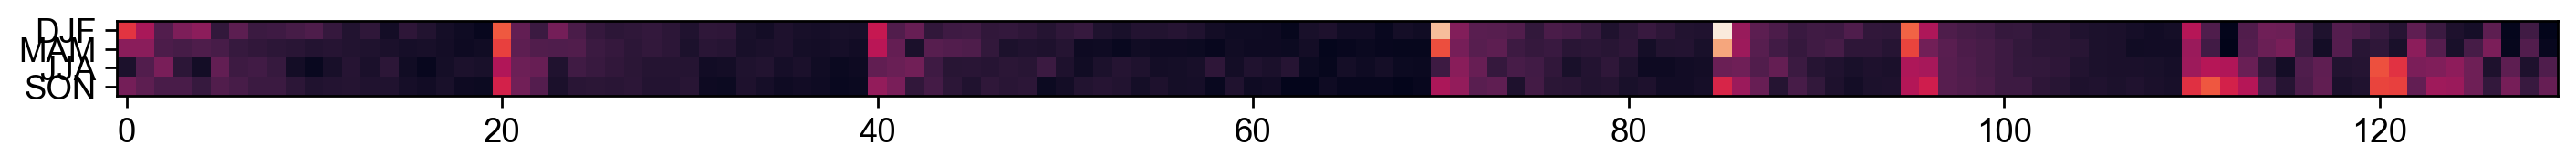

In [11]:
def plot_pc_distribution():
    fig, ax = plt.subplots()

    pc_std = ds_reduced.groupby(round_to(ds_reduced.time % 1, 1/4, 1)).std().compute()
    ax.set_yticks(range(4), ["DJF", "MAM", "JJA", "SON"])

    ax.imshow(pc_std)

plot_pc_distribution()

# Seasonality

In [16]:
# ds = xr.open_zarr(
#     get_data_path() / "cmip6/CESM2/piControl/seasonal_anomalies_detrended.zarr"
# )#.isel(time=slice(100))
ds = xr.open_zarr(
    get_data_path() / "cmip6/MPI-ESM1-2-LR/past2k/seasonal_anomalies.zarr"
)#.isel(time=slice(100))
ds = ds[["tas", "tos", "rsut", "rlut", "ohc300", "eei", "siconc"]]
ds = ds.isel(
    time=np.random.default_rng(682652).choice(np.arange(len(ds.time)), 100, replace=False)
)
ds = ds.load()
ds

<xarray.Dataset> Size: 52MB
Dimensions:  (time: 100, lat: 90, lon: 180)
Coordinates:
  * lat      (lat) float64 720B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float64 1kB 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time     (time) float64 800B 1.374e+03 1.005e+03 1.762e+03 ... 548.0 130.8
Data variables:
    tas      (time, lat, lon) float32 6MB -1.352 -1.253 ... -0.5528 -0.5709
    tos      (time, lat, lon) float32 6MB nan nan nan ... -9.155e-05 -9.155e-05
    rsut     (time, lat, lon) float32 6MB 0.2388 0.2361 0.234 ... 1.263 1.247
    rlut     (time, lat, lon) float32 6MB -1.976 -1.694 -1.707 ... 2.179 2.158
    ohc300   (time, lat, lon) float32 6MB nan nan nan ... -7.927e+07 -8.254e+07
    eei      (time, lat, lon) float32 6MB 2.123 1.845 1.86 ... -1.361 -1.326
    siconcn  (time, lat, lon) float32 6MB nan nan nan ... -0.01013 -0.01027
    siconcs  (time, lat, lon) float32 6MB nan nan nan nan ... nan nan nan nan

In [ ]:
def fit_individual_eof(fields, standardize_by_season):
    # Individual EOFs
    k = 20
    l = 0
    k_direct = {
        "tas": 20,
        "tos": 20,
        "rsut": 20,
        "rlut": 20,
    }

    mapper = PhysicalSpaceForecastSpaceMapper(
        k,
        l,
        k_direct,
        standardize_by_season=standardize_by_season
    )
    with logging_disabled():
        mapper.fit(to_math_order(stack_state(ds[fields])))
    # Trigger computation
    mapper = pickle.loads(pickle.dumps(mapper))

    return mapper

mapper_season = fit_individual_eof(["tas", "tos", "rsut", "rlut"], True)
mapper_notseason = fit_individual_eof(["tas", "tos", "rsut", "rlut"], False)

In [ ]:
def calculate_variance_remaining(ds, mapper):
    return (compute_field_stds(mapper.truncate_dataset(ds, True)) / compute_field_stds(ds)).compute() * 100

In [ ]:
calculate_variance_remaining(ds, mapper_season)

In [ ]:
calculate_variance_remaining(ds, mapper_notseason)

In [ ]:
mapper_season.get_joint_mode(2)

In [ ]:
def visualize_eof_difference(
    mapper_notseason,
    mapper_season,
    field,
    n_leading=5,
):
    fig, axs = plt.subplots(
        n_leading,
        3,
        figsize=(3 * 8, 3.9 * n_leading),
        subplot_kw=dict(projection=ccrs.EqualEarth(central_longitude=180)),
        dpi=100
    )

    def get_mode(mapper, i):
        if not mapper.direct_fields:
            with logging_disabled():
                return mapper.get_joint_mode(i)[field]
        else:
            return mapper.get_individual_mode(field, i)

    eofs = []
    eofs_diff = []
    for i in range(n_leading):
        mode_notseason = get_mode(mapper_notseason, i)
        mode_season = get_mode(mapper_season, i)
        if area_weighted_rmse(mode_notseason, -mode_season, []).compute().item() < area_weighted_rmse(mode_notseason, mode_season, []).compute().item():
            mode_season = -mode_season
        eofs.extend([mode_notseason, mode_season, mode_season - mode_notseason])
        eofs_diff.append(mode_season - mode_notseason)

    plot_field(axs.flatten(), eofs, cmap=cmocean.cm.balance, colorbar=True, n_level=60, cbar_aspect=40)

    for ax in axs.flat:
        ax.coastlines()
        
    add_subplot_headers([f"Mode {i+1}" for i in range(n_leading)], ["Std. normal", "Std. by season", "Difference (By season - normal)"])

visualize_eof_difference(
    mapper_notseason, mapper_season, "tas", 10
)